In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,learning_curve

pd.options.display.max_rows = 150
pd.options.display.max_columns = 150

In [8]:
df = pd.read_csv('../data/data_clear.csv')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881197 entries, 0 to 881196
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   City            881197 non-null  object 
 1   State           881197 non-null  object 
 2   BankState       881197 non-null  object 
 3   Term            881197 non-null  float64
 4   NoEmp           881197 non-null  float64
 5   NewExist        881197 non-null  object 
 6   CreateJob       881197 non-null  int64  
 7   RetainedJob     881197 non-null  int64  
 8   UrbanRural      881197 non-null  object 
 9   RevLineCr       881197 non-null  int64  
 10  LowDoc          881197 non-null  int64  
 11  GrAppv          881197 non-null  float64
 12  is_default      881197 non-null  int64  
 13  have_franchise  881197 non-null  int64  
 14  sector          881197 non-null  object 
 15  in_recession    881197 non-null  int64  
dtypes: float64(3), int64(7), object(6)
memory usage: 107.6+ 

In [10]:
df.head()

,City,State,BankState,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,GrAppv,is_default,have_franchise,sector,in_recession
0,EVANSVILLE,IN,OH,84.0,4.0,New,0,0,Undefined,0,1,60000.0,0,0,Retail trade,0
1,NEW PARIS,IN,IN,60.0,2.0,New,0,0,Undefined,0,1,40000.0,0,0,Accommodation and food services,0
2,BLOOMINGTON,IN,IN,180.0,7.0,Existing,0,0,Undefined,0,0,287000.0,0,0,Health care and social assistance,0
3,BROKEN ARROW,OK,OK,60.0,2.0,Existing,0,0,Undefined,0,1,35000.0,0,0,Sector not known,0
4,ORLANDO,FL,FL,240.0,14.0,Existing,7,7,Undefined,0,0,229000.0,0,0,Sector not known,0


In [11]:
df.columns

Index(['City', 'State', 'BankState', 'Term', 'NoEmp', 'NewExist', 'CreateJob',
       'RetainedJob', 'UrbanRural', 'RevLineCr', 'LowDoc', 'GrAppv',
       'is_default', 'have_franchise', 'sector', 'in_recession'],
      dtype='object')

In [12]:
X = df.drop(['City', 'CreateJob','RetainedJob', 'RevLineCr',"is_default"], axis=1)
y = df['is_default']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, shuffle=True,stratify=y, random_state=42)

In [13]:
numeric_features = ["Term","NoEmp","GrAppv"]
categorial_features = ["State","BankState", "LowDoc","NewExist","UrbanRural", 'have_franchise', 'sector', 'in_recession']

In [14]:
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import OneHotEncoder,PolynomialFeatures

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

In [15]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorial_features)
    ]
   , remainder="passthrough" 
)

In [16]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier()
pipe_dummy = Pipeline([
     ('preprocessor', preprocessor),
     ('dummy', dummy)
])

In [17]:
len(y_train)

793077

In [18]:
len(y_test)

88120

In [19]:
pipe_dummy.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State', 'BankState',
                                                   'LowDoc', 'NewExist',
                                                   'UrbanRural',
                                                   'have_franchise', 'sector',
                                                   'in_recession'])])),
                ('dummy', DummyClassifier())])

In [20]:
print(pipe_dummy.score(X_train,y_train))
print(pipe_dummy.score(X_test,y_test))

0.8257205794645412
0.8257262823422605


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
tree = RandomForestClassifier(n_estimators=100,min_samples_split=250,random_state=42)

In [22]:
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

pipe = Pipeline([
     ('preprocessor', preprocessor),
     ('decisiontree', tree)
])

In [23]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State', 'BankState',
                                                   'LowDoc', 'NewExist',
                                                   'UrbanRural',
                                                   'have_franchise', 'sector',
                                                   'in_recession'])])),
                ('decisiontree',
                 RandomForestClassifier(min_samples_split=250,
                                        random_state=42))])

In [24]:
print(pipe.score(X_train,y_train))
print(pipe.score(X_test,y_test))

0.9256276502785984
0.9230367680435769


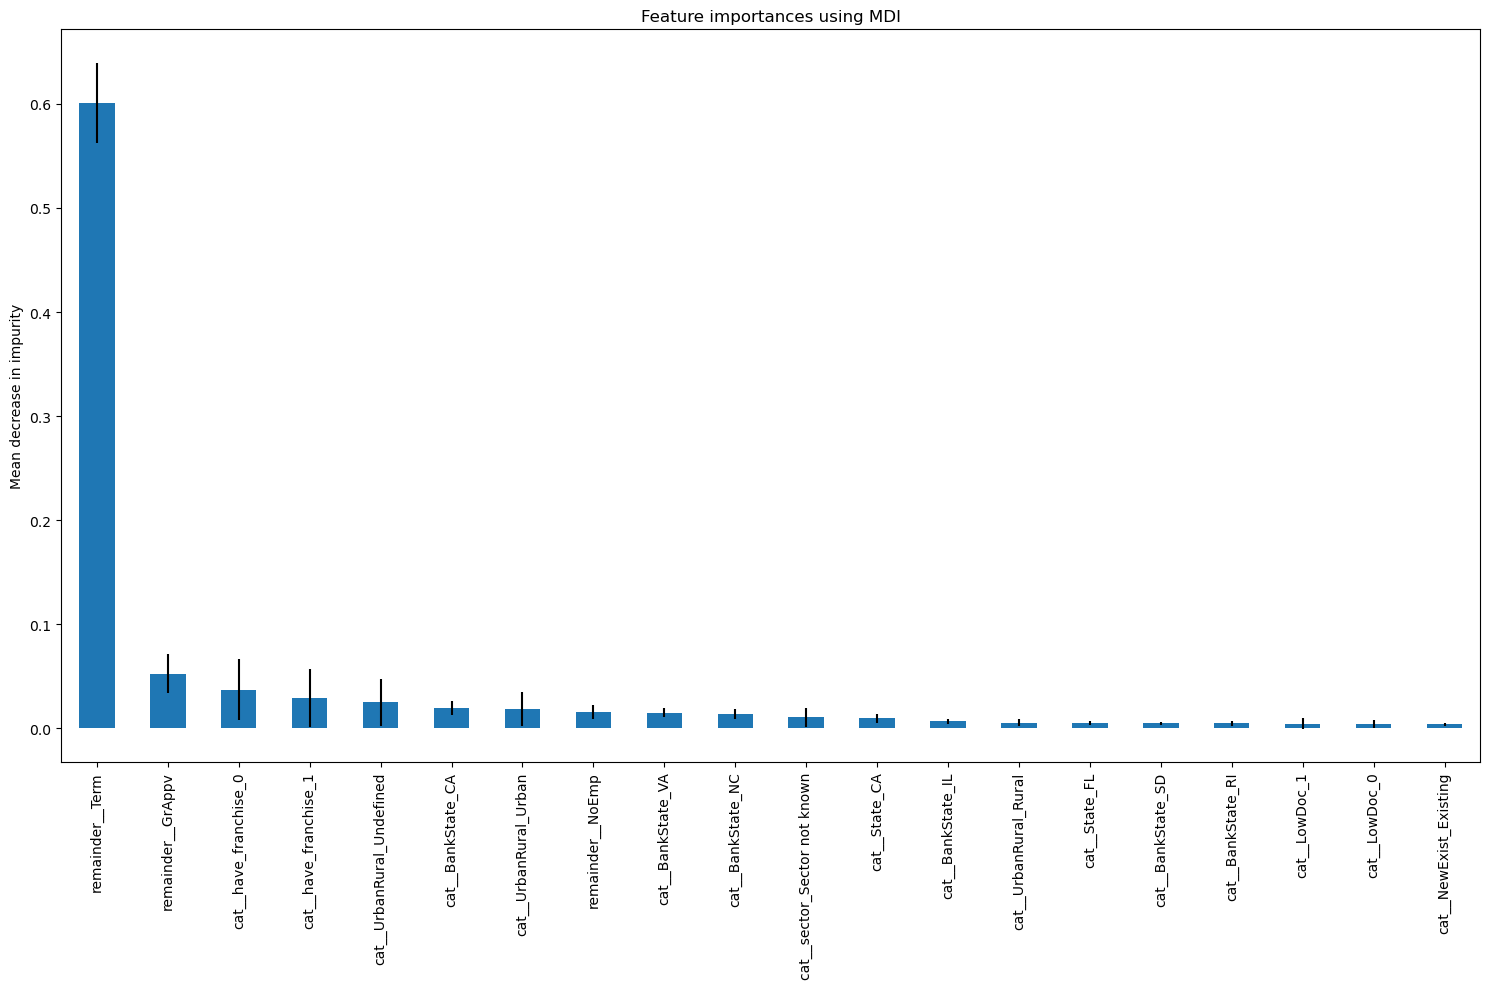

In [25]:
importances = pipe[-1].feature_importances_
std = np.std([tree.feature_importances_ for tree in pipe[-1].estimators_], axis=0)

forest_importances = pd.DataFrame({"feature_importances":importances,"std":std},index=pipe[0].get_feature_names_out())
forest_importances.sort_values(by="feature_importances",ascending=False,inplace=True)
forest_importances = forest_importances.head(20)

fig, ax = plt.subplots(figsize=(15,10))
forest_importances["feature_importances"].plot.bar(yerr=forest_importances["std"], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_train,y_pred=pipe.predict(X_train)))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96    654860
           1       0.88      0.66      0.76    138217

    accuracy                           0.93    793077
   macro avg       0.91      0.82      0.86    793077
weighted avg       0.92      0.93      0.92    793077



In [27]:
print(classification_report(y_true=y_test,y_pred=pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     72763
           1       0.87      0.65      0.75     15357

    accuracy                           0.92     88120
   macro avg       0.90      0.82      0.85     88120
weighted avg       0.92      0.92      0.92     88120



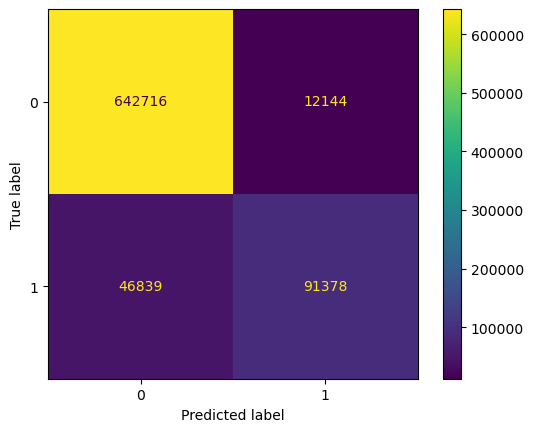

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true=y_train,y_pred=pipe.predict(X_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe[-1].classes_)
disp.plot()

plt.show()


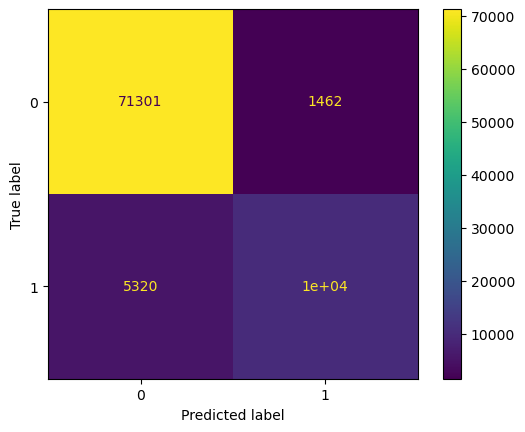

In [29]:
cm = confusion_matrix(y_true=y_test,y_pred=pipe.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe[-1].classes_)
disp.plot()

plt.show()


In [30]:
# train_sizes, train_scores, test_scores = learning_curve(pipe,X_train,y_train,cv=3,train_sizes=np.linspace(0.1, 1.0, 50))                                    
                                           
# plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
# plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
# plt.xlabel('train_sizes')
# plt.legend()
# plt.show()

In [31]:
# from sklearn import tree
# import graphviz 

# dot_data = tree.export_graphviz(pipe[-1].estimators_[0],out_file=None, 
#                      feature_names=new_columns,  
#                       filled=True, rounded=True,
#                       class_names=["False","True"],
#                      special_characters=True)  
# graph = graphviz.Source(dot_data)
# graph.render("model_test",format="pdf")
# graph

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorial_features),
        ("num",StandardScaler(),numeric_features)
        ]
)

logisticreg=Pipeline([
     ('preprocessor', preprocessor),
     ('logisticregression', LogisticRegression(random_state=42,max_iter=10000))
     ]
)


In [33]:
logisticreg.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State', 'BankState',
                                                   'LowDoc', 'NewExist',
                                                   'UrbanRural',
                                                   'have_franchise', 'sector',
                                                   'in_recession']),
                                                 ('num', StandardScaler(),
                                                  ['Term', 'NoEmp',
                                                   'GrAppv'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=10000, random_state=42))])

In [34]:
from sklearn.inspection import permutation_importance


result = permutation_importance(logisticreg, X_train, y_train, n_repeats=10,
                                random_state=0)
result.importances_mean

result.importances_std

array([1.22646974e-04, 1.76533075e-04, 1.94556210e-04, 7.55833166e-05,
       6.60343397e-05, 1.47926161e-04, 6.78417321e-05, 1.10883968e-04,
       1.06583957e-04, 1.35223585e-04, 3.49090388e-05])

In [35]:
col_name = logisticreg[0].get_feature_names_out()

coef = pd.DataFrame(data=logisticreg[-1].coef_.reshape(-1,1), columns=['coefs'], index=col_name)

In [36]:
coef = coef.sort_values(by="coefs",ascending=False)
coef.head(30)

,coefs
cat__BankState_SC,1.479309
cat__BankState_PR,1.298303
cat__BankState_VA,0.990511
cat__BankState_DC,0.909822
cat__BankState_CA,0.883806
cat__State_GA,0.759671
cat__BankState_CT,0.679267
cat__State_MS,0.649080
cat__BankState_WV,0.643476
cat__State_AR,0.609497


In [37]:
print(logisticreg.score(X_train,y_train))
print(logisticreg.score(X_test,y_test))

0.8637509346507338
0.8646391284611893
